### Library imports

In [877]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Function definition

In [878]:
# Calculate measures of central tendency
def central_tendency(col):
    print(f"\tMean: {col.mean():.2f}")
    print(f"\tMedian: {col.median():.2f}")
    print(f"\tMode: {col.mode().values[0]:.2f}")
    return

# Calculate measures of spread
def measures_of_spread(col):
    print(f"\tRange: {col.max() - col.min():.2f}")
    print(f"\tVariance: {col.var():.2f}")
    print(f"\tStandard Deviation: {col.std():.2f}")
    return

# Get outliers lower bound
def get_cutoff_value_lower(col):
    IQR = col.quantile(0.75) - col.quantile(0.25)
    lower_bound_total_funding = col.quantile(0.25) - 1.5 * IQR
    return float(lower_bound_total_funding)

# Get outliers upper bound
def get_cutoff_value_upper(col):
    IQR = col.quantile(0.75) - col.quantile(0.25)
    upper_bound_total_funding = col.quantile(0.75) + 1.5 * IQR
    return float(upper_bound_total_funding)

# Drop outliers
def drop_outliers(col, key):
    mask = (col[key] >= get_cutoff_value_lower(col[key])) & (col[key] <= get_cutoff_value_upper(col[key]))
    return col[mask]

# Capping method
def capping_method(df, col):
    max_value = df[col].mean() + (3 * df[col].std())
    min_value = df[col].mean() - (3 * df[col].std())
    return df[col].clip(lower=min_value, upper=max_value)

# Function for plotting
def hist_plotting(df, x, y, hue, title):
    plt.figure(figsize=(8, 6))
    sns.histplot(x=x, y=y , data=df, color='skyblue', hue=hue)
    # plt.xlabel('country')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return 0

def impute_outliers(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z_score_threshold = 3.0
    is_outlier = (df[column_name] - mean).abs() > z_score_threshold * std
    df.loc[is_outlier, column_name] = mean
    return df


Cleaning data import values for nulls, errors and column types

In [879]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/notpeter/crunchbase-data/master/companies.csv')
df.head(3)


,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30


In [880]:
# Replacing nulls for costs and changing to 0
df['funding_total_usd'] = df['funding_total_usd'].replace('-', np.nan)
df['funding_total_usd'].fillna(0, inplace=True)
df.dropna(subset=['name'], inplace=True)

# Editing columns data type for ease of handling
df['funding_total_usd'] = df['funding_total_usd'].astype(float)
df['funding_rounds'] = df['funding_rounds'].astype(float)


# Parsing date columns
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
df.loc[:, 'founded_at'] = df['first_funding_at']
df = df.dropna(subset=['first_funding_at', 'last_funding_at'])

# Remove comment below to view null data from a specific column
# df[df['country_code'].isnull()]
# Remove comment below to review total errors per column
# df.isnull().sum()

### Measuring Central Tendency and Spread

Calculate measures of central tendency and spread for a startup

In [881]:
print("Total Funding Raised:")
central_tendency(df['funding_total_usd'])
measures_of_spread(df['funding_total_usd'])

print("\nNumber of Funding Rounds:")
central_tendency(df['funding_rounds'])
measures_of_spread(df['funding_rounds'])

Total Funding Raised:
	Mean: 14923495.81
	Median: 1000000.00
	Mode: 0.00
	Range: 30079503000.00
	Variance: 28604425623420144.00
	Standard Deviation: 169128429.38

Number of Funding Rounds:
	Mean: 1.73
	Median: 1.00
	Mode: 1.00
	Range: 18.00
	Variance: 1.85
	Standard Deviation: 1.36


For "Total Funding Raised" the average funding raised by startups is $14,919,146 USD with an average of 1.7 rounds of funding per startup but it is highly likely that some startups have received exceptionally large funding amounts, which significantly skews the distribution. The mean is much higher than the median, indicating the presence of high-value outliers because probably few startups have received exceptionally large amounts of funding. The mode proves this too because there are many startups with 0 funding (but can also be due to missing data). The variance and range are very large which indicates a presence of outliers at the upper end of the distribution.

There is a lot less variation in the "Funding rounds" and when observing the difference of measures of central tendency which suggests that the data may be less affected by outliers. The measures of spread also contain moderate levels of variance which indicate that the outliers are not as noticeable.


### Outlier analysis

In [882]:
print("Funding USD Cutoff Values:")
print("\tLower Bound:", get_cutoff_value_lower(df['funding_total_usd'])) 
print("\tUpper Bound:", get_cutoff_value_upper(df['funding_total_usd'])) 

print("Funding Rounds Cutoff Values:")
print("\tLower Bound:", get_cutoff_value_lower(df['funding_rounds'])) 
print("\tUpper Bound:", get_cutoff_value_upper(df['funding_rounds'])) 

Funding USD Cutoff Values:
	Lower Bound: -10103850.125
	Upper Bound: 16946416.875
Funding Rounds Cutoff Values:
	Lower Bound: -0.5
	Upper Bound: 3.5


#### Dropping outliers...

In [883]:
print("Funding USD Central Tendency & Spread Values:")
dropped_outliers_df = drop_outliers(df, 'funding_total_usd')
central_tendency(dropped_outliers_df['funding_total_usd'])
measures_of_spread(dropped_outliers_df['funding_total_usd'])

print("Funding Rounds Central Tendency & Spread Values:")
dropped_outliers_df = drop_outliers(df, 'funding_rounds')
central_tendency(dropped_outliers_df['funding_rounds'])
measures_of_spread(dropped_outliers_df['funding_rounds'])

Funding USD Central Tendency & Spread Values:
	Mean: 2296085.22
	Median: 500000.00
	Mode: 0.00
	Range: 16940000.00
	Variance: 13653619317206.98
	Standard Deviation: 3695080.42
Funding Rounds Central Tendency & Spread Values:
	Mean: 1.39
	Median: 1.00
	Mode: 1.00
	Range: 2.00
	Variance: 0.42
	Standard Deviation: 0.65


By simply dropping the outliers, the variance and standard deviation have significantly dropped therefore we can confirm a high presence of outliers. By removing them, the results should be a lot less skewed but there could be a potentially high loss of data following this method.

##### Imputing the outliers...

In [884]:
print("Funding USD Central Tendency & Spread Values:")
df_impute = impute_outliers(df, 'funding_total_usd')
central_tendency(df_impute['funding_total_usd'])
measures_of_spread(df_impute['funding_total_usd'])

print("Funding USD Central Tendency & Spread Values:")
df_impute = impute_outliers(df, 'funding_rounds')
central_tendency(df_impute['funding_rounds'])
measures_of_spread(df_impute['funding_rounds'])

Funding USD Central Tendency & Spread Values:
	Mean: 11016818.26
	Median: 1000000.00
	Mode: 0.00
	Range: 515000000.00
	Variance: 1139344002905151.25
	Standard Deviation: 33754170.16
Funding USD Central Tendency & Spread Values:
	Mean: 1.59
	Median: 1.00
	Mode: 1.00
	Range: 4.00
	Variance: 0.92
	Standard Deviation: 0.96


This method varies quite a bit from the dropping method. It has a higher deviation and variance in general but is still much better than the original dataset that was not handling the outliers whatsoever.

#### Using the capping method

In [885]:
print("Funding USD Central Tendency & Spread Values:")
capping_method_df = capping_method(df, 'funding_total_usd')
central_tendency(capping_method_df)
measures_of_spread(capping_method_df)

#print("Funding Rounds Central Tendency & Spread Values:")
print("Funding USD Central Tendency & Spread Values:")
capping_method_df = capping_method(df, 'funding_rounds')
central_tendency(capping_method_df)
measures_of_spread(capping_method_df)

Funding USD Central Tendency & Spread Values:
	Mean: 9293929.05
	Median: 1000000.00
	Mode: 0.00
	Range: 112279328.73
	Variance: 449918870459192.19
	Standard Deviation: 21211291.11
Funding USD Central Tendency & Spread Values:
	Mean: 1.57
	Median: 1.00
	Mode: 1.00
	Range: 3.46
	Variance: 0.84
	Standard Deviation: 0.92


We can see that each method provides different values of central tendency and measures of spread but there is little difference between different methods once we have dealt with outliers, no matter in which any way. It seems what is important is to first notice that there are outliers and then deal them in whichever way is best depending on the dataset and variance observed.

### Sampling Techniques
Let's drop all outliers and draw a random sample of 1000 for each variable and see the results.

In [886]:
random_sample_df = drop_outliers(df, 'funding_total_usd').sample(n=1000) #random_state=42
central_tendency(random_sample_df['funding_total_usd'])
measures_of_spread(random_sample_df['funding_total_usd'])

random_sample_df = drop_outliers(df, 'funding_rounds').sample(n=1000) #random_state=42
central_tendency(random_sample_df['funding_rounds'])
measures_of_spread(random_sample_df['funding_rounds'])

	Mean: 2440255.19
	Median: 486587.00
	Mode: 0.00
	Range: 16593715.00
	Variance: 14649564712376.54
	Standard Deviation: 3827474.98
	Mean: 1.40
	Median: 1.00
	Mode: 1.00
	Range: 2.00
	Variance: 0.39
	Standard Deviation: 0.62


We can see that depending on the sample selected we will get different results  but if we run the cell multiple times, the results dont vary more than 0.60-0.68 which indicates that the values tend to cluster around the mean. In other words, the data points are not widely scattered and are relatively close to the average value.

### Subsetting and Sampling
We are getting only the companies based only in United States and sampling randomly for our observations.

In [887]:
samples_sizes_to_test = [10, 100, 500, 1000]

for size in samples_sizes_to_test:
    random_sample_df = drop_outliers(df, 'funding_total_usd').sample(n=100)
    usa_mask = random_sample_df['country_code'] == 'USA'
    usa_df = random_sample_df[usa_mask]
    print("Funding USD Central Tendency & Spread Values for sample size ", size, ":")
    central_tendency(usa_df['funding_total_usd'])
    measures_of_spread(usa_df['funding_total_usd'])

Funding USD Central Tendency & Spread Values for sample size  10 :
	Mean: 3937148.37
	Median: 2232500.00
	Mode: 0.00
	Range: 16000000.00
	Variance: 18835851074140.92
	Standard Deviation: 4340028.93
Funding USD Central Tendency & Spread Values for sample size  100 :
	Mean: 2557812.72
	Median: 1275000.00
	Mode: 0.00
	Range: 12643228.00
	Variance: 12466503215036.92
	Standard Deviation: 3530793.57
Funding USD Central Tendency & Spread Values for sample size  500 :
	Mean: 1828514.45
	Median: 600000.00
	Mode: 0.00
	Range: 15599906.00
	Variance: 9435565629628.33
	Standard Deviation: 3071736.58
Funding USD Central Tendency & Spread Values for sample size  1000 :
	Mean: 2574940.85
	Median: 560000.00
	Mode: 0.00
	Range: 14000000.00
	Variance: 13759518123596.61
	Standard Deviation: 3709382.45


Sample size affects the statistics, such as mean and median, but the range remains consistent. The mode many times is is also consistent with 0.00, indicating that a significant number of data points have no recorded funding across all samples.

In conclusion, the choice of sample size can significantly impact the summary statistics, and the presence of zero funding values can still significantly skew results in any sample.

### Subsetting, Sampling, Benchmarking and Visualisation:
Now we are filtering only the companies based in each of the United States, Canada, France, Germany, China, India and South Korea. We will analyse the same dataset to find average number of days taken for a startup to be funded for each of the aforesaid countries and compare results

Measures of central tendency and spread 1000 :
	Mean: 137.67
	Median: 0.00
	Mode: 0.00
	Range: 1047.00
	Variance: 73317.15
	Standard Deviation: 270.77


/var/folders/wv/f74f4dpn75v5cgd05yy1xcs80000gn/T/ipykernel_3926/2247427896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_countries_df['founded_to_first_funding_days'] = (selected_countries_df['last_funding_at'] - selected_countries_df['first_funding_at']).dt.days


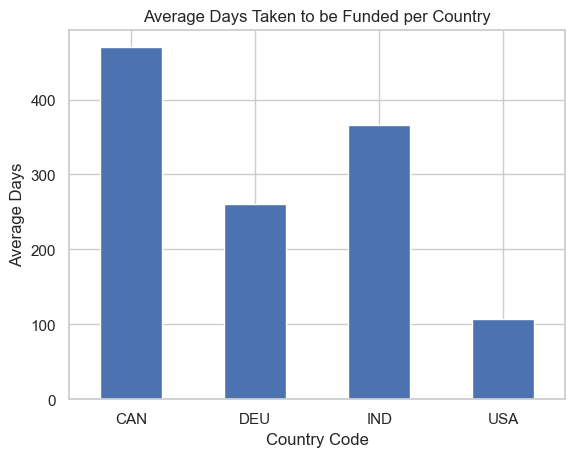

In [888]:
selected_countries = ['USA', 'CAN', 'FRA', 'DEU', 'CHN', 'IND', 'KOR']
random_sample_df = drop_outliers(dropped_outliers_df, 'funding_total_usd').sample(n=100)
selected_countries_mask = random_sample_df['country_code'].isin(selected_countries)
selected_countries_df = random_sample_df[selected_countries_mask]
selected_countries_df['founded_to_first_funding_days'] = (selected_countries_df['last_funding_at'] - selected_countries_df['first_funding_at']).dt.days
print("Measures of central tendency and spread", size, ":")
central_tendency(selected_countries_df['founded_to_first_funding_days'])
measures_of_spread(selected_countries_df['founded_to_first_funding_days'])

selected_countries_df.groupby('country_code')['founded_to_first_funding_days'].mean().astype(int).plot(kind='bar')
sns.set(style='whitegrid')
plt.title('Average Days Taken to be Funded per Country')
plt.xlabel('Country Code')
plt.ylabel('Average Days')
plt.xticks(rotation=0)
plt.show()

We can see that the average number of days taken for a startup to be funded will depend entirely on the sample selected. Sometimes some countries are not selected therefore the data should not be considered as this will show as 0 days. It is important to consider this use-case when analysing either by deleting the country in question or making sure to tell analysts that the country in question was not analysed in the sample. We can also consider instead another sampling method, we can force each country to have a specific sample lets say 50 per country in order to avoid nulls later on. This would potentially solve our sampling issue and still keep the dataset random.

### Probability Theory: 
Find the probability for startups of being funded within the first 6 months since their creation for the overall dataset and then repeat the same sequence of procedures for the countries United States, Canada, France, Germany, China, and India (While making necessary computations, assume that there are 30 days in each month at an average). Report your results in writing and compare them varying across various geographies. Create appropriate plots (if necessary) to draw conclusions if necessary.

Probability for startups of being funded within the first 6 months:
Probability for USA: 70.91%
Probability for CAN: 76.88%
Probability for FRA: 76.93%
Probability for DEU: 70.11%
Probability for CHN: 71.00%
Probability for IND: 85.03%


/var/folders/wv/f74f4dpn75v5cgd05yy1xcs80000gn/T/ipykernel_3926/404840986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_outliers_df['founded_at'] = pd.to_datetime(dropped_outliers_df['founded_at'])
/var/folders/wv/f74f4dpn75v5cgd05yy1xcs80000gn/T/ipykernel_3926/404840986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_outliers_df['first_funding_at'] = pd.to_datetime(dropped_outliers_df['first_funding_at'])
/var/folders/wv/f74f4dpn75v5cgd05yy1xcs80000gn/T/ipykernel_3926/404840986.py

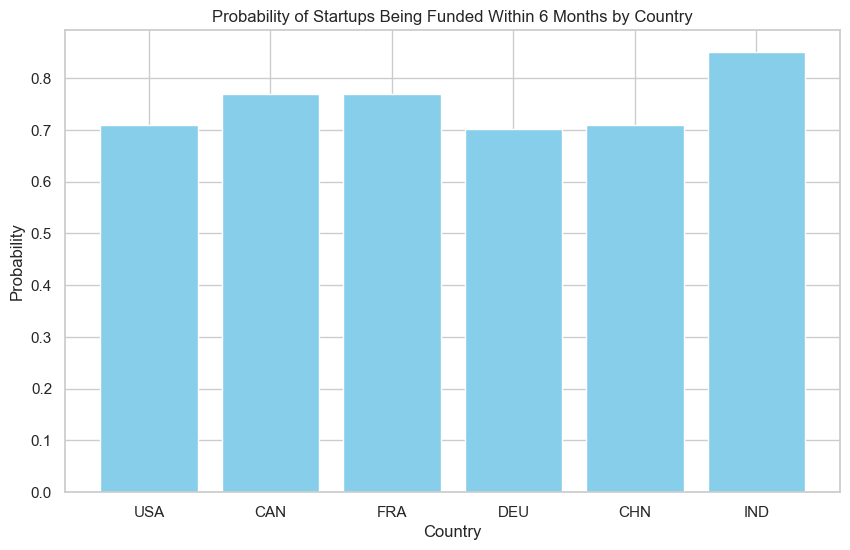

In [933]:
print("Probability for startups of being funded within the first 6 months:")
dropped_outliers_df = drop_outliers(df, 'funding_total_usd')
dropped_outliers_df['founded_at'] = pd.to_datetime(dropped_outliers_df['founded_at'])
dropped_outliers_df['first_funding_at'] = pd.to_datetime(dropped_outliers_df['first_funding_at'])
dropped_outliers_df['months_to_funding'] = (dropped_outliers_df['last_funding_at'] - dropped_outliers_df['first_funding_at']) / pd.Timedelta(days=30)
within_6_months = (dropped_outliers_df['months_to_funding'] <= 6)
overall_probability = within_6_months.mean()

# Repeat the process for each specified country
countries = ['USA', 'CAN', 'FRA', 'DEU', 'CHN', 'IND']
country_probabilities = {}
for country in countries:
    country_df = dropped_outliers_df[dropped_outliers_df['country_code'] == country]
    country_probability = (country_df['months_to_funding'] <= 6).mean()
    country_probabilities[country] = country_probability
    print("Probability for {}: {:.2%}".format(country, country_probability))

# Extracting countries and their corresponding probabilities
countries = list(country_probabilities.keys())
probabilities = list(country_probabilities.values())

plt.figure(figsize=(10, 6))
plt.bar(countries, probabilities, color='skyblue')
plt.title('Probability of Startups Being Funded Within 6 Months by Country')
plt.xlabel('Country')
plt.ylabel('Probability')
plt.show()

### Advanced Probability Theory
Find the probability for startups of being funded within the first 6 months given the fact that they are based on software domain and then repeat the same sequence of procedures for the countries United States, Canada, France, Germany, China, and India(Use the value ‘Software’ in the appropriate variable of your choice).

In [890]:
print("Q8")

Q8


### Advanced Probability Theory
Find the probability that a startup belongs to health care domain given the fact that it was funded within the first 6 months and then repeat the same sequence of procedures for the countries United States, Canada, France, Germany, China, and India (Use the value ‘Health Care’ in the appropriate variable of your choice). Report your results based on probability found as a whole and then comparison across various countries.


In [891]:
print("Q9")

Q9


### Advanced Probability Theory
Repeat the analysis in Question 8 but this time perform the operation by first sampling your dataset randomly by getting only 10 data points in the beginning and report your observations as that in Question 8. Next, attempt to repeat the aforesaid procedure for dataset of increasing sample size of 50, 100, 200, 300, 400, 500, 600, and 800. Plot the various probabilities observed against the number of data points you have obtained and write in your own words the observations. 

In [892]:
print("Q10")

Q10
